# Unsupervised Learning - Clustering 

Our Goal is to find the model that can incorporate new training set data without retraining the entire model. Only two clustering models in scikit-learn provide this option (the models that have partial_fit()). Thus, we can try:

* sklearn.cluster.MiniBatchKMeans
* sklearn.cluster.Birch

http://scikit-learn.org/stable/modules/scaling_strategies.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")
import pickle

from sklearn.cluster import MiniBatchKMeans #has partial_fit()
from sklearn.cluster import Birch #has partial_fit(), but the result is very similar with MiniBatchKMeans
from sklearn.cluster import DBSCAN  # works for clustering by "gap"

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import IncrementalPCA # has partial_fit()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [373]:
# I am using the same dataframes as I used for supervised learning
train = pd.read_pickle('paws_train.pkl')
test = pd.read_pickle('paws_test.pkl')

In [191]:
train.shape

(1746, 114)

In [192]:
test.shape

(200, 114)

In [193]:
features_analytical = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq',
       'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio',
       'log_fluctuation']

features60 = ['0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59'] 
        # since q is in range 0 - 0.6, we have only zeros in "60" - "99"

features_analytical_and_60 = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq',
       'Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio',
       'log_fluctuation','0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59' ]

In [194]:
# we need PCA for visualization
def doPCA(data, num_of_componets):
    pca = IncrementalPCA(n_components=num_of_componets)
    pca.fit(data)
    return pca

<a id=bins></a>
# Bad Data

## features_analytical = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq','Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio','log_fluctuation']

### 1.1 MiniBatchKMeans Clustering using PCA

**I tried different number of clusters and "5" is the most reasonable:**

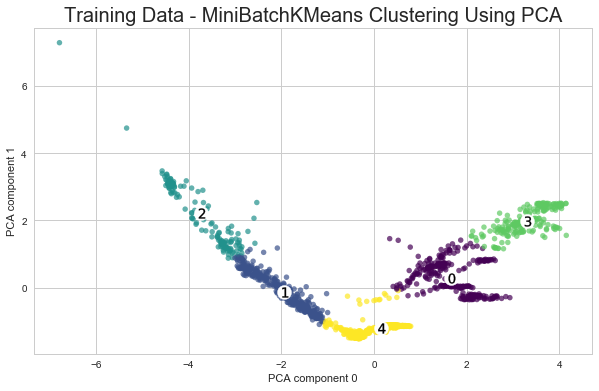

In [195]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(train[features_analytical])
pca = doPCA(scaler.transform(train[features_analytical]), 2)
transformed_data = pca.transform(scaler.transform(train[features_analytical]))

clusterer4_pca = MiniBatchKMeans(n_clusters=5, random_state=10)
cluster_labels4_pca = clusterer4_pca.fit_predict(transformed_data)

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

centers = clusterer4_pca.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=100, c='black')
plt.title('Training Data - MiniBatchKMeans Clustering Using PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

**This clastering makes some sence: form left to right:**

**bad data, precursor, form, form with precursor or structure.**

In [196]:
pca.explained_variance_ratio_

array([ 0.52552906,  0.22082153])

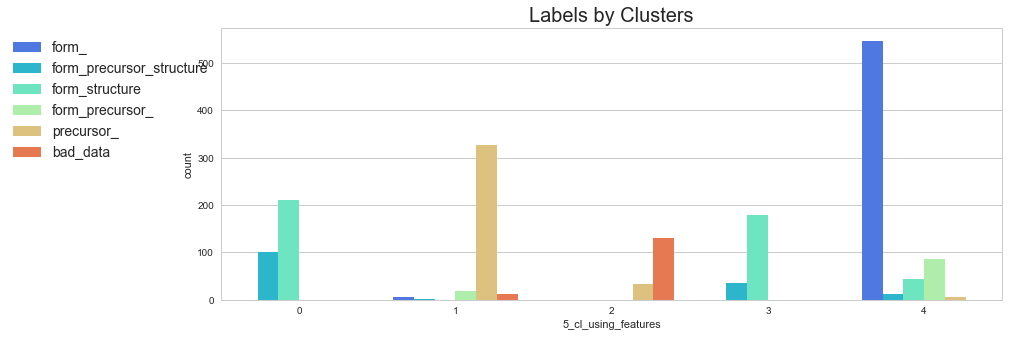

In [197]:
cluster_labels = clusterer4_pca.predict(transformed_data)
train['5_cl_using_features'] = cluster_labels 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train, hue='str_label',x = '5_cl_using_features',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

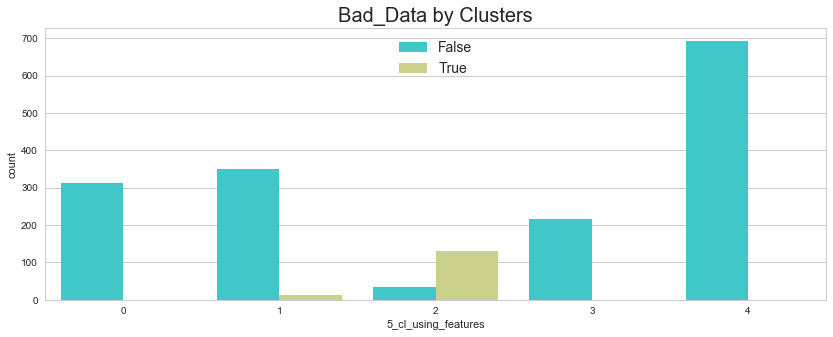

In [198]:
cluster_labels = clusterer4_pca.predict(transformed_data)
train['5_cl_using_features'] = cluster_labels 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Bad_Data by Clusters", fontsize=20);
sns.countplot(data=train, hue='bad_data',x = '5_cl_using_features',palette='rainbow')
axes.legend(fontsize=14)

**We can try use cluster 2 to create "bad_data labels"**

In [199]:
train.loc[(train["5_cl_using_features"]== 2) , "bad_data_pred"] = 1
train.loc[train["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(train["bad_data_pred"], train["bad_data"])

0.97422680412371132

**Let's test it on our testing set:**

In [200]:
transformed_data_test = pca.transform(scaler.transform(test[features_analytical]))
cluster_labels = clusterer4_pca.predict(transformed_data_test)
test['cluster'] = cluster_labels 

test.loc[(test["cluster"]== 2) , "bad_data_pred"] = 1
test.loc[test["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(test["bad_data_pred"], test["bad_data"])

0.96999999999999997

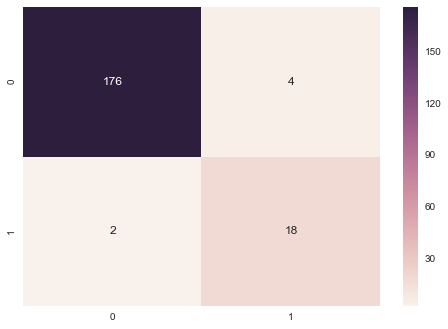

In [201]:
cnf_matrix = confusion_matrix(test['bad_data'], test['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

**We have 2 false negative and 4 false positive**

In [202]:
difference = test[test['bad_data'] != test['bad_data_pred']]
difference[['name', 'str_label','bad_data','bad_data_pred']]

,name,str_label,bad_data,bad_data_pred
217,R1/R1_reac_0010_dz_bgsub,bad_data,True,0.0
1029,R4/R4_saxs_0016_dz_bgsub,precursor_,False,1.0
225,R1/R1_reac_0018_dz_bgsub,bad_data,True,0.0
912,R3/R3_SAXS_0021_dz_bgsub,precursor_,False,1.0
909,R3/R3_SAXS_0018_dz_bgsub,precursor_,False,1.0
902,R3/R3_SAXS_0011_dz_bgsub,precursor_,False,1.0


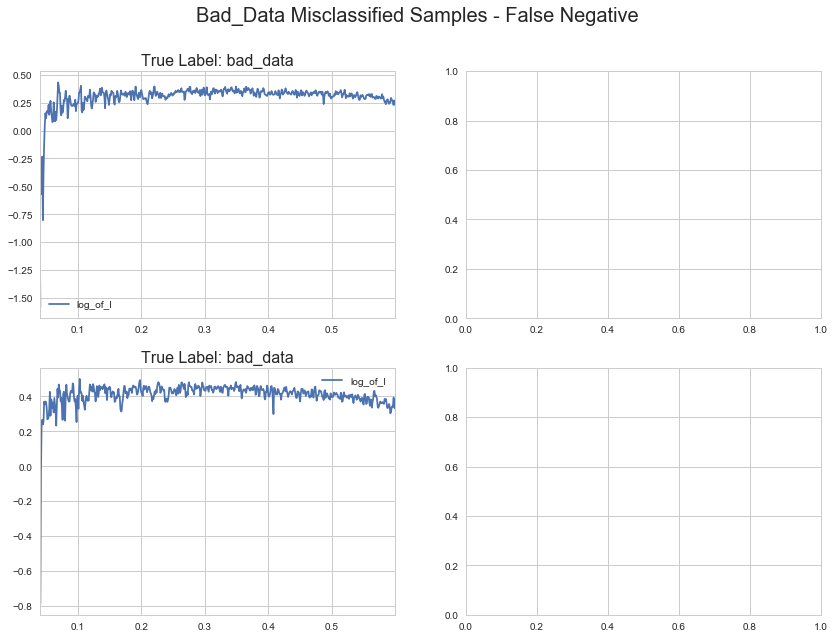

In [203]:
false_negative = difference[difference['bad_data'] == True]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Bad_Data Misclassified Samples - False Negative", fontsize=20)
st.set_y(0.97)

for n in range(len(false_negative)): 
    d = false_negative.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-3]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

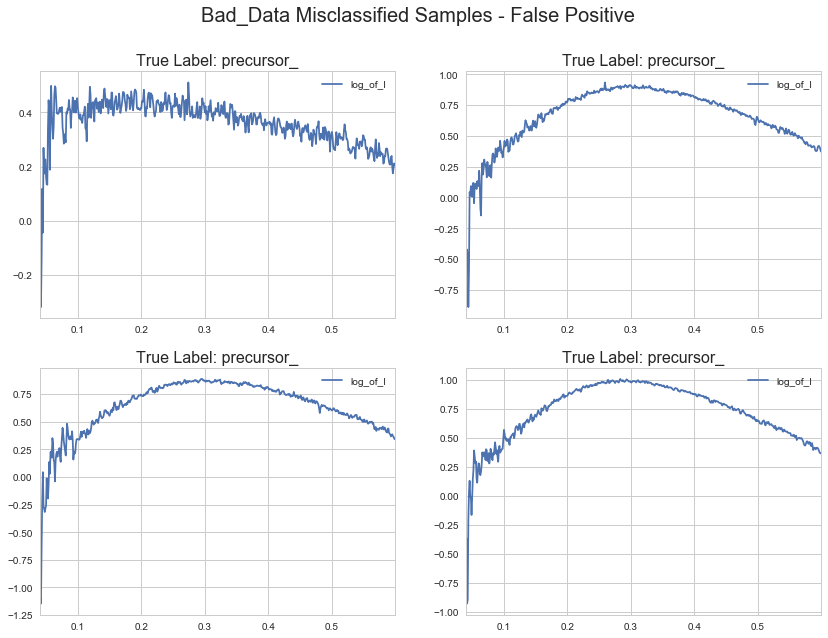

In [204]:
false_negative = difference[difference['bad_data'] == False]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Bad_Data Misclassified Samples - False Positive", fontsize=20)
st.set_y(0.97)

for n in range(len(false_negative)): 
    d = false_negative.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-3]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

The this model put "bad_data" label on some "precursors only."

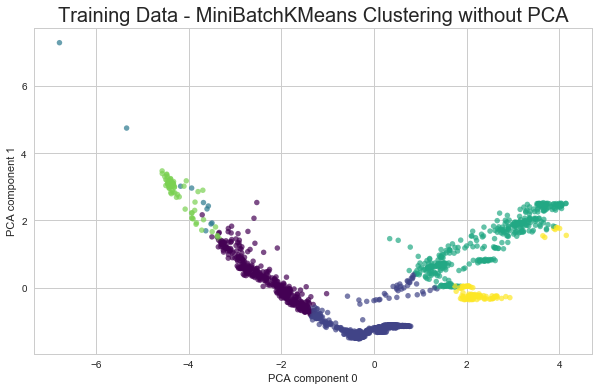

In [393]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features_analytical])
pca = doPCA(scaler.transform(train[features_analytical]), 2)
transformed_data = pca.transform(scaler.transform(train[features_analytical]))

clusterer4_pca = MiniBatchKMeans(n_clusters=6, random_state=10)
cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(train[features_analytical]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

plt.title('Training Data - MiniBatchKMeans Clustering without PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

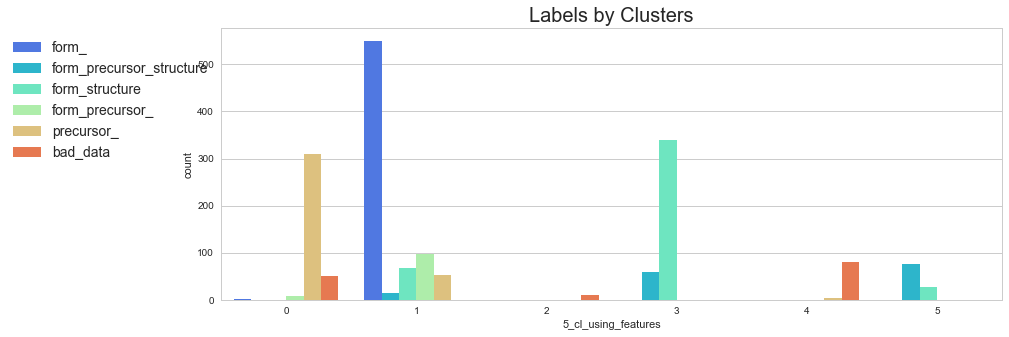

In [394]:
train['5_cl_using_features'] = cluster_labels4_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train, hue='str_label',x = '5_cl_using_features',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [395]:
#del train["bad_data_pred"]

train.loc[((train["5_cl_using_features"]== 2)  | (train["5_cl_using_features"]== 4)), "bad_data_pred"] = 1
train.loc[train["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(train["bad_data_pred"], train["bad_data"])

0.96964490263459335

In [396]:
del test["bad_data_pred"]

cluster_labels = clusterer4_pca.predict(scaler.transform(test[features_analytical]))
test['cluster'] = cluster_labels 

test.loc[((test["cluster"]== 2) | (test["cluster"]== 4)) , "bad_data_pred"] = 1
test.loc[test["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(test["bad_data_pred"], test["bad_data"])

0.94499999999999995

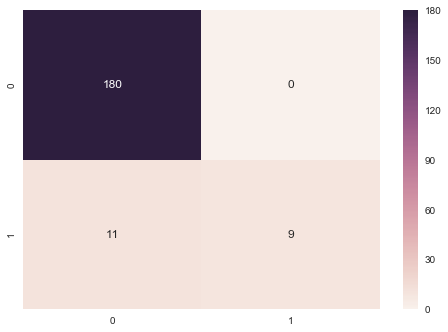

In [397]:
cnf_matrix = confusion_matrix(test['bad_data'], test['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

In [398]:
difference = test[test['bad_data'] != test['bad_data_pred']]
difference[['name', 'str_label','bad_data','bad_data_pred']]

,name,str_label,bad_data,bad_data_pred
297,R12/R12_SAXS_0005_dz_bgsub,bad_data,True,0.0
217,R1/R1_reac_0010_dz_bgsub,bad_data,True,0.0
225,R1/R1_reac_0018_dz_bgsub,bad_data,True,0.0
226,R1/R1_reac_0019_dz_bgsub,bad_data,True,0.0
623,R13/R13_0025_dz_bgsub,bad_data,True,0.0
314,R12/R12_SAXS_0022_dz_bgsub,bad_data,True,0.0
608,R13/R13_0010_dz_bgsub,bad_data,True,0.0
611,R13/R13_0013_dz_bgsub,bad_data,True,0.0
210,R1/R1_reac_0003_dz_bgsub,bad_data,True,0.0
300,R12/R12_SAXS_0008_dz_bgsub,bad_data,True,0.0


We have 11 false negative and 0 false positive - it is good sicne we do not loose any "good data."

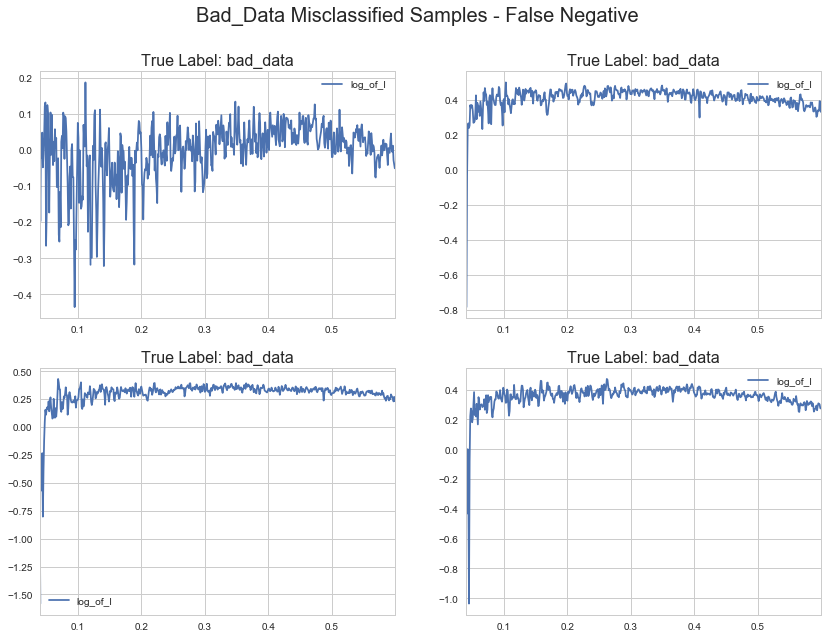

In [399]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Bad_Data Misclassified Samples - False Negative", fontsize=20)
st.set_y(0.97)

for n in range(4): 
    d = difference.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-3]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

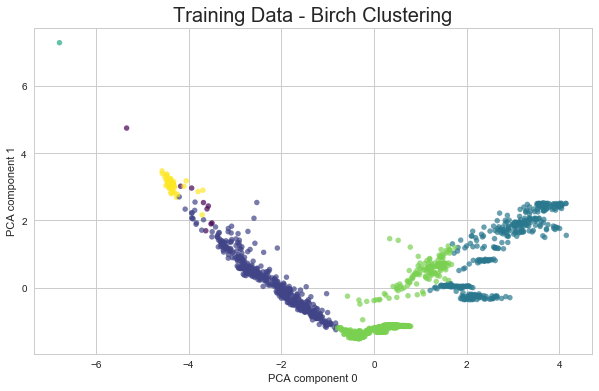

In [382]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features_analytical])
pca = doPCA(scaler.transform(train[features_analytical]), 2)
transformed_data = pca.transform(scaler.transform(train[features_analytical]))

clusterer4_pca = Birch(n_clusters=6)
cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(train[features_analytical]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

plt.title('Training Data - Birch Clustering', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

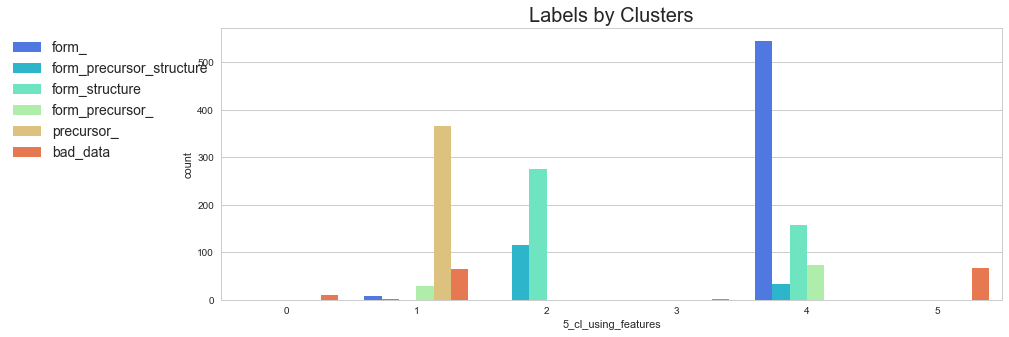

In [383]:
train['5_cl_using_features'] = cluster_labels4_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train, hue='str_label',x = '5_cl_using_features',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [384]:
del train["bad_data_pred"]

train.loc[((train["5_cl_using_features"]== 5)  | (train["5_cl_using_features"]== 0)| (train["5_cl_using_features"]== 3)), "bad_data_pred"] = 1
train.loc[train["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(train["bad_data_pred"], train["bad_data"])

0.9627720504009164

In [385]:
del test["bad_data_pred"]

cluster_labels = clusterer4_pca.predict(scaler.transform(test[features_analytical]))
test['cluster'] = cluster_labels 

test.loc[((test["cluster"]== 5) | (test["cluster"]== 0) | (test["cluster"]== 3) ) , "bad_data_pred"] = 1
test.loc[test["bad_data_pred"]!= 1, "bad_data_pred"] = 0

accuracy_score(test["bad_data_pred"], test["bad_data"])

0.93999999999999995

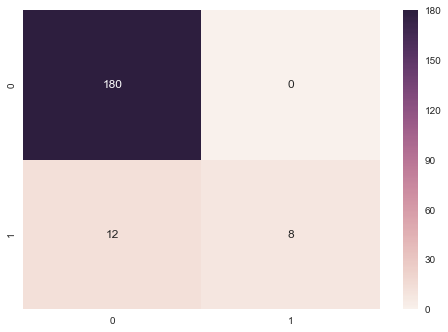

In [386]:
cnf_matrix = confusion_matrix(test['bad_data'], test['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 12 false negative and 0 false positive - it is good sicne we do not loose any "good data."

Thus, KMean with PCA gives us a better accuracy (training 0.974, testing 0.970), but we have 4 false positive. KMean without PCA does not have false positive, but it is less accurate. 

<a id = analytical> </a>
# Precursor and Form Labels

## features60 = ['0','1', '2', '3', '4', '5',  ...... '56', '57', '58', '59'] 

Now I will use only samples with "bad_data" = False.

In [205]:
#now we need only "good" data
train_good = train[train['bad_data']==False]
train_good.shape

(1604, 116)

In [206]:
test_good = test[test['bad_data_pred']==False]
test_good.shape

(178, 116)

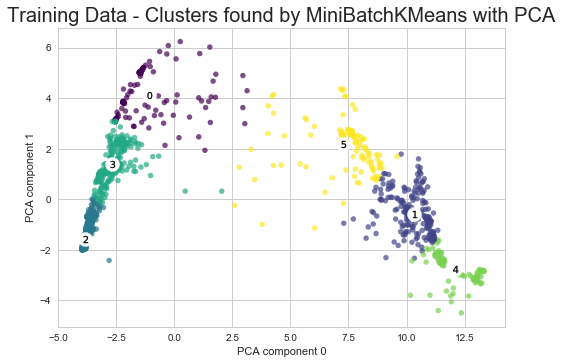

In [207]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(train[features60])
pca = doPCA(scaler.transform(train_good[features60]), 2)
transformed_data = pca.transform(scaler.transform(train_good[features60]))

clusterer_pca = MiniBatchKMeans(n_clusters=6, random_state=10, n_init= 20)
cluster_labels2_pca = clusterer_pca.fit_predict(transformed_data)

plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

centers = clusterer_pca.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, color='black')
plt.title('Training Data - Clusters found by MiniBatchKMeans with PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

**We got an interesting result: the right part (clusters 5,4,and 1 )includes "precursor_only"**
**Almost all samples in the left part has "form" **

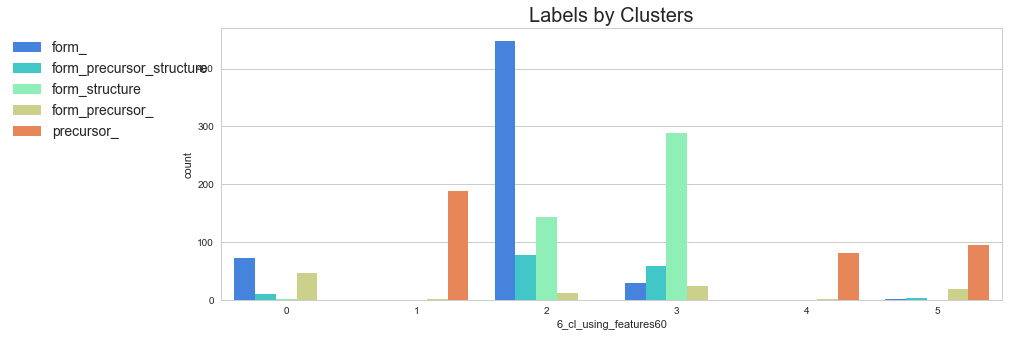

In [208]:
train_good['6_cl_using_features60'] = cluster_labels2_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train_good, hue='str_label',x = '6_cl_using_features60',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

**We can use clusters 1, 4, and 5 to create label "precursor" = True**
**and clusters 0, 2, and 3 to create label "form" = True**

In [210]:
train_good.loc[((train_good["6_cl_using_features60"]== 1) |(train_good["6_cl_using_features60"]== 4) | 
                (train_good["6_cl_using_features60"]== 5)) , "precursor_pred"] = 1
train_good.loc[train_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(train_good["precursor_pred"], train_good["precursor"])

0.8559850374064838

In [211]:
train_good.loc[((train_good["6_cl_using_features60"]== 0) |(train_good["6_cl_using_features60"]== 2) | 
                (train_good["6_cl_using_features60"]== 3)) , "form_pred"] = 1
train_good.loc[train_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(train_good["form_pred"], train_good["form"])

0.98379052369077302

**Test this model on our testing set:**

In [212]:
transformed_data_test = pca.transform(scaler.transform(test_good[features60]))
test_good['cluster'] = clusterer_pca.predict(transformed_data_test)

test_good.loc[((test_good["cluster"]== 1) |(test_good["cluster"]== 4) | 
                (test_good["cluster"]== 5)) , "precursor_pred"] = 1
test_good.loc[test_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(test_good["precursor_pred"], test_good["precursor"])

0.8089887640449438

In [213]:
test_good.loc[((test_good["cluster"]== 0) |(test_good["cluster"]== 2) | 
                (test_good["cluster"]== 3)) , "form_pred"] = 1
test_good.loc[test_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(test_good["form_pred"], test_good["form"])

0.97752808988764039

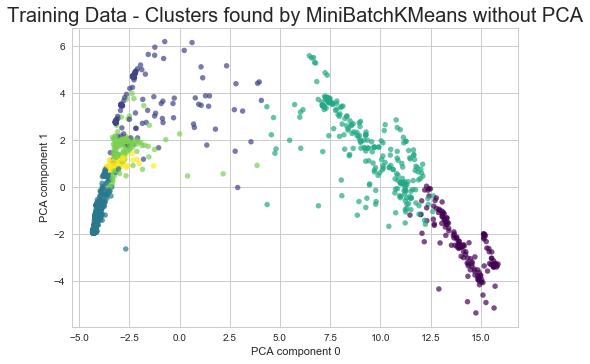

In [221]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features60])
pca = doPCA(scaler.transform(train_good[features60]), 2)
transformed_data = pca.transform(scaler.transform(train_good[features60]))

clusterer_pca = MiniBatchKMeans(n_clusters=6, random_state=10, n_init= 20)
cluster_labels2_pca = clusterer_pca.fit_predict(scaler.transform(train_good[features60]))

plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

plt.title('Training Data - Clusters found by MiniBatchKMeans without PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

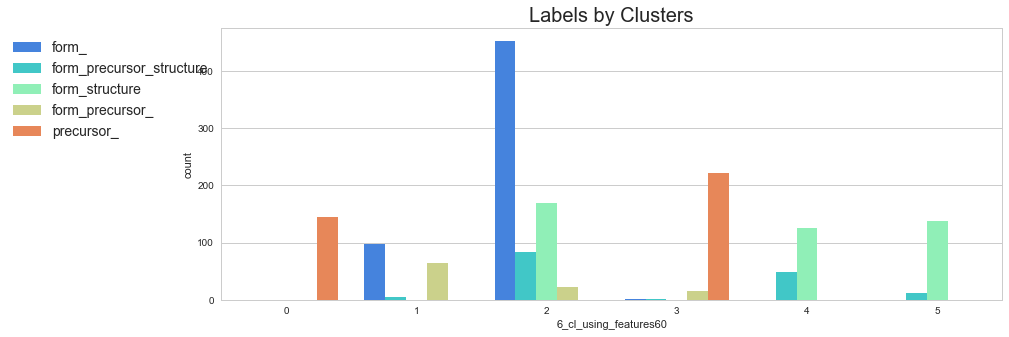

In [222]:
train_good['6_cl_using_features60'] = cluster_labels2_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train_good, hue='str_label',x = '6_cl_using_features60',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [223]:
del train_good["precursor_pred"]
train_good.loc[((train_good["6_cl_using_features60"]== 0) |
                (train_good["6_cl_using_features60"]== 3)) , "precursor_pred"] = 1
train_good.loc[train_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(train_good["precursor_pred"], train_good["precursor"])

0.85162094763092266

In [224]:
del train_good["form_pred"]
train_good.loc[((train_good["6_cl_using_features60"]== 1) |(train_good["6_cl_using_features60"]== 2) | 
                (train_good["6_cl_using_features60"]== 4) | (train_good["6_cl_using_features60"]== 5)) , "form_pred"] = 1
train_good.loc[train_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(train_good["form_pred"], train_good["form"])

0.98815461346633415

**Test this model on our testing set:**

In [225]:
del test_good["precursor_pred"]
test_good['cluster'] = clusterer_pca.predict(scaler.transform(test_good[features60]))

test_good.loc[((test_good["cluster"]== 0) |(test_good["cluster"]== 3)) , "precursor_pred"] = 1
test_good.loc[test_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(test_good["precursor_pred"], test_good["precursor"])

0.8089887640449438

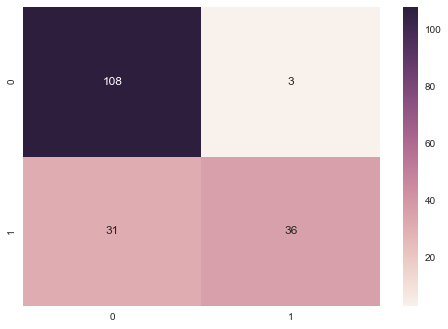

In [227]:
cnf_matrix = confusion_matrix(test_good['precursor'], test_good['precursor_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 31 false negative and 3 false positive.

In [236]:
del test_good["form_pred"]

test_good.loc[((test_good["cluster"]== 1) |(test_good["cluster"]== 2) | 
               (test_good["cluster"]== 4) |(test_good["cluster"]== 5)) , "form_pred"] = 1
test_good.loc[test_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(test_good["form_pred"], test_good["form_pred"])

1.0

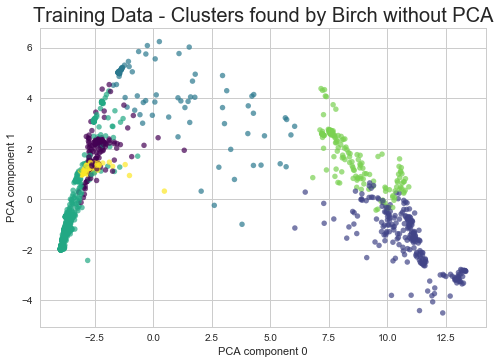

In [272]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features60])
pca = doPCA(scaler.transform(train_good[features60]), 2)
transformed_data = pca.transform(scaler.transform(train_good[features60]))

clusterer_pca = Birch(n_clusters=6)
cluster_labels2_pca = clusterer_pca.fit_predict(scaler.transform(train_good[features60]))

plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

plt.title('Training Data - Clusters found by Birch without PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

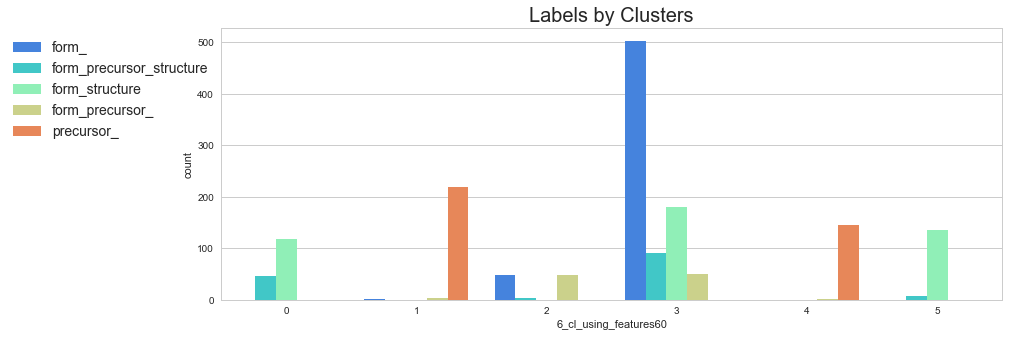

In [273]:
train_good['6_cl_using_features60'] = cluster_labels2_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train_good, hue='str_label',x = '6_cl_using_features60',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [274]:
del train_good["precursor_pred"]
train_good.loc[((train_good["6_cl_using_features60"]== 1) |(train_good["6_cl_using_features60"]== 4)) ,
               "precursor_pred"] = 1
train_good.loc[train_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(train_good["precursor_pred"], train_good["precursor"])

0.84538653366583538

In [275]:
del train_good["form_pred"]
train_good.loc[((train_good["6_cl_using_features60"]== 0) |(train_good["6_cl_using_features60"]== 2) | 
               (train_good["6_cl_using_features60"]== 3) |(train_good["6_cl_using_features60"]== 5)) ,
               "form_pred"] = 1
train_good.loc[train_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(train_good["form_pred"], train_good["form"])

0.99563591022443887

**Testing set:**

In [277]:
test_good['cluster'] = clusterer_pca.predict(scaler.transform(test_good[features60]))

test_good.loc[((test_good["cluster"]== 1) |(test_good["cluster"]== 4)) , "precursor_pred"] = 1
test_good.loc[test_good["precursor_pred"]!= 1, "precursor_pred"] = 0

accuracy_score(test_good["precursor_pred"], test_good["precursor"])

0.8146067415730337

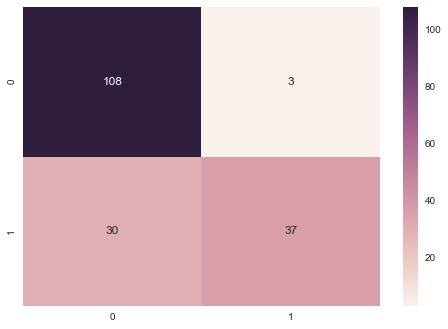

In [279]:
cnf_matrix = confusion_matrix(test_good['precursor'], test_good['precursor_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 30 false negative and 3 false positive.

In [280]:
difference = test_good[test_good['precursor'] != test_good['precursor_pred']]
difference[['name', 'str_label','precursor','precursor_pred']].head()

,name,str_label,precursor,precursor_pred
862,R3/R3_cool_0041_dz_bgsub,form_precursor_structure,True,0.0
318,R12/R12_SAXS_0026_dz_bgsub,form_,False,1.0
217,R1/R1_reac_0010_dz_bgsub,bad_data,False,1.0
1244,R5/R5_SAXS_0048_dz_bgsub,form_precursor_structure,True,0.0
947,R3/R3_SAXS_0056_dz_bgsub,form_precursor_structure,True,0.0


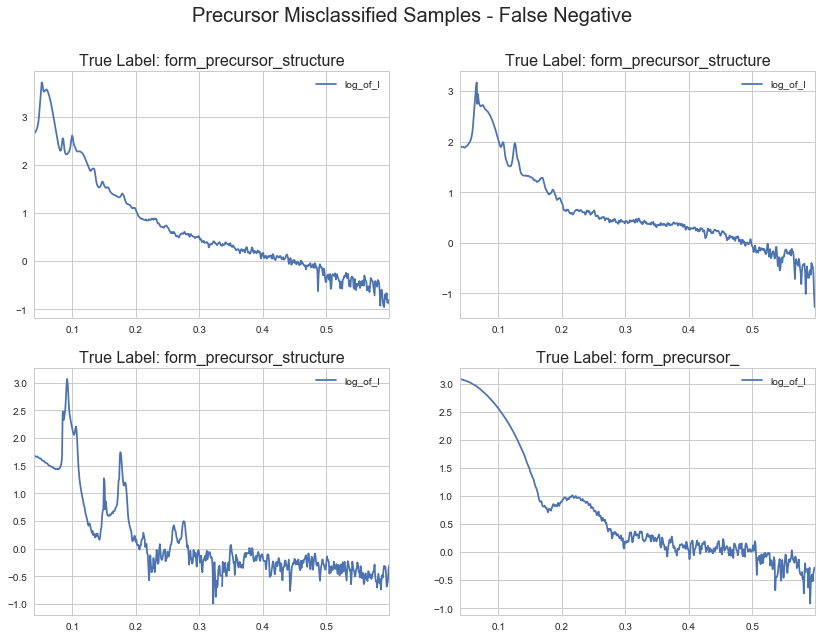

In [281]:
false_negative = difference[difference['precursor'] == True]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Precursor Misclassified Samples - False Negative", fontsize=20)
st.set_y(0.97)

for n in range(4): 
    d = false_negative.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-5]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

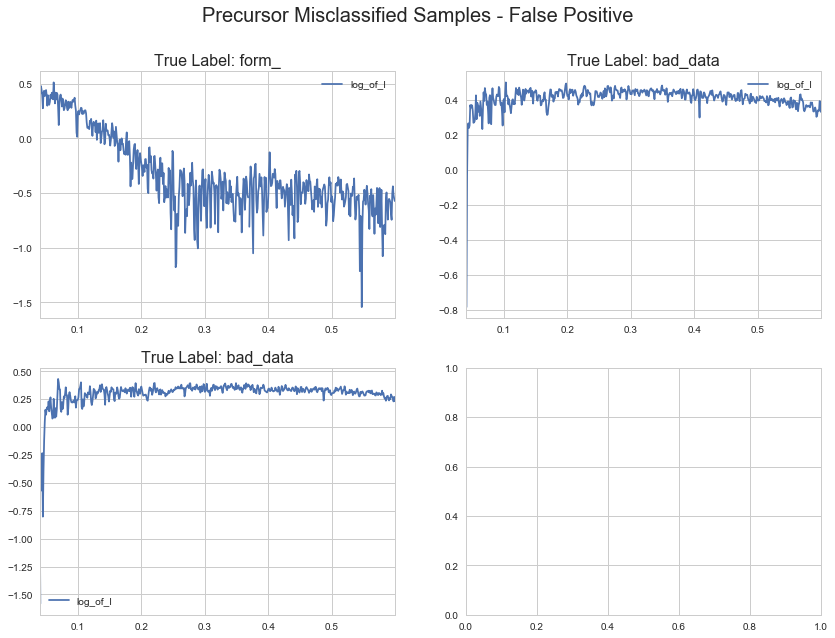

In [282]:
false_pos = difference[difference['precursor'] == False]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Precursor Misclassified Samples - False Positive", fontsize=20)
st.set_y(0.97)

for n in range(len(false_pos)): 
    d = false_pos.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-5]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

In [278]:
del test_good["form_pred"]

test_good.loc[((test_good["cluster"]== 0) |(test_good["cluster"]== 2) | 
               (test_good["cluster"]== 3) |(test_good["cluster"]== 5)) , "form_pred"] = 1
test_good.loc[test_good["form_pred"]!= 1, "form_pred"] = 0

accuracy_score(test_good["form_pred"], test_good["form_pred"])

1.0

**For Precursor and Form labels we got the best result using Birch without PCA.**

# Structure

## features_analytical = ['q_Imax', 'Imax_over_Imean', 'Imax_over_Ilowq','Imax_over_Ihighq', 'Imax_sharpness', 'low_q_ratio', 'high_q_ratio','log_fluctuation']

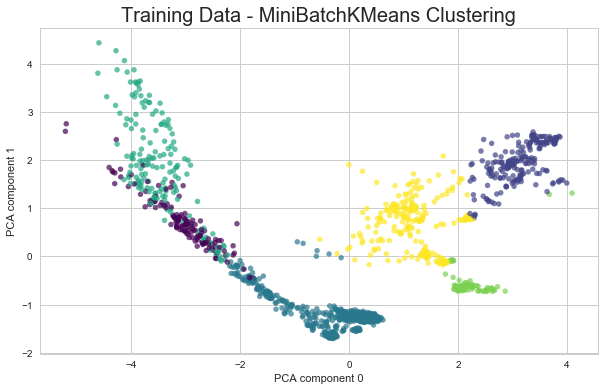

In [314]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features_analytical])
pca = doPCA(scaler.transform(train_good[features_analytical]), 2)
transformed_data = pca.transform(scaler.transform(train_good[features_analytical]))

clusterer4_pca = MiniBatchKMeans(n_clusters=6, random_state=10)
cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(train_good[features_analytical]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

plt.title('Training Data - MiniBatchKMeans Clustering', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

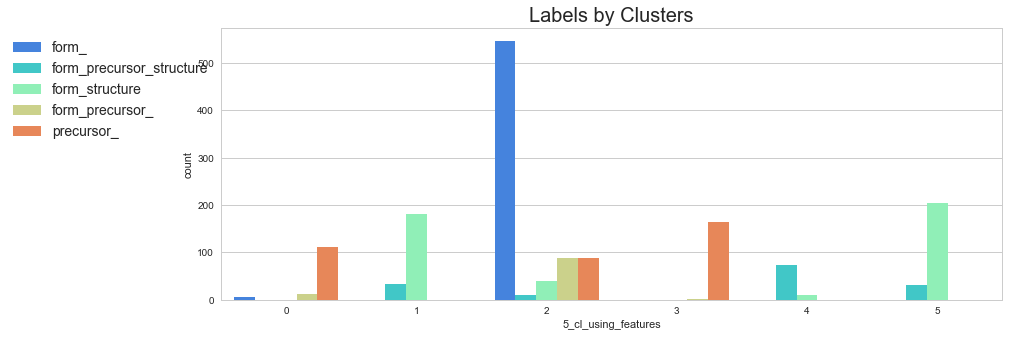

In [315]:
train_good['5_cl_using_features'] = cluster_labels4_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train_good, hue='str_label',x = '5_cl_using_features',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [316]:
train_good.loc[((train_good["5_cl_using_features"]== 1) |(train_good["5_cl_using_features"]== 4) |
                (train_good["5_cl_using_features"]== 5)) ,"structure_pred"] = 1
train_good.loc[train_good["structure_pred"]!= 1, "structure_pred"] = 0

accuracy_score(train_good["structure_pred"], train_good["structure"])

0.972568578553616

In [317]:
del test_good["structure_pred"]

test_good['cluster'] = clusterer4_pca.predict(scaler.transform(test_good[features_analytical]))

test_good.loc[((test_good["cluster"]== 1) |(test_good["cluster"]== 4)
              |(test_good["cluster"]== 5)) , "structure_pred"] = 1
test_good.loc[test_good["structure_pred"]!= 1, "structure_pred"] = 0

accuracy_score(test_good["structure_pred"], test_good["structure"])

0.9831460674157303

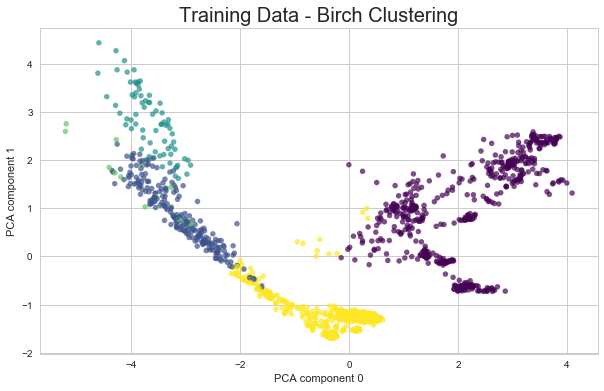

In [318]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features_analytical])
pca = doPCA(scaler.transform(train_good[features_analytical]), 2)
transformed_data = pca.transform(scaler.transform(train_good[features_analytical]))

clusterer4_pca = Birch(n_clusters=5)
cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(train_good[features_analytical]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

plt.title('Training Data - Birch Clustering', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

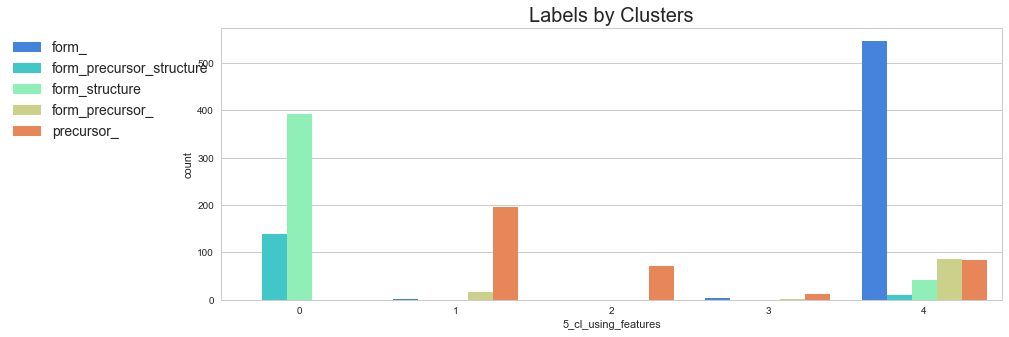

In [319]:
train_good['5_cl_using_features'] = cluster_labels4_pca 

fig, axes = plt.subplots(figsize=(14,5))
axes.set_title("Labels by Clusters", fontsize=20);
sns.countplot(data=train_good, hue='str_label',x = '5_cl_using_features',palette='rainbow')
axes.legend(loc=0, ncol=1, bbox_to_anchor=(0, 0, 0, 1), fontsize=14)

In [320]:
train_good.loc[((train_good["5_cl_using_features"]== 0) ) ,"structure_pred"] = 1
train_good.loc[train_good["structure_pred"]!= 1, "structure_pred"] = 0

accuracy_score(train_good["structure_pred"], train_good["structure"])

0.972568578553616

In [321]:
del test_good["structure_pred"]

test_good['cluster'] = clusterer4_pca.predict(scaler.transform(test_good[features_analytical]))

test_good.loc[((test_good["cluster"]== 0)) , "structure_pred"] = 1
test_good.loc[test_good["structure_pred"]!= 1, "structure_pred"] = 0

accuracy_score(test_good["structure_pred"], test_good["structure"])

0.9831460674157303

**We got the same accuracy using Birch and KMean clustering**

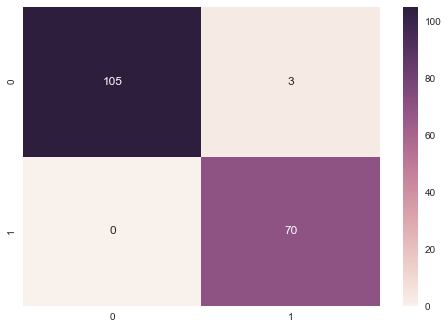

In [322]:
cnf_matrix = confusion_matrix(test_good["structure_pred"], test_good["structure"])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

We have 3 false positive.

In [325]:
difference = test_good[test_good['structure'] != test_good['structure_pred']]
difference[['name', 'str_label','structure','structure_pred']]

,name,str_label,structure,structure_pred
1264,R5/R5_SAXS_0068_dz_bgsub,form_structure,True,0.0
415,R12/R12cooling2rd_0008_dz_bgsub,form_structure,True,0.0
785,R2/R2_SAXS_0039_dz_bgsub,form_precursor_structure,True,0.0


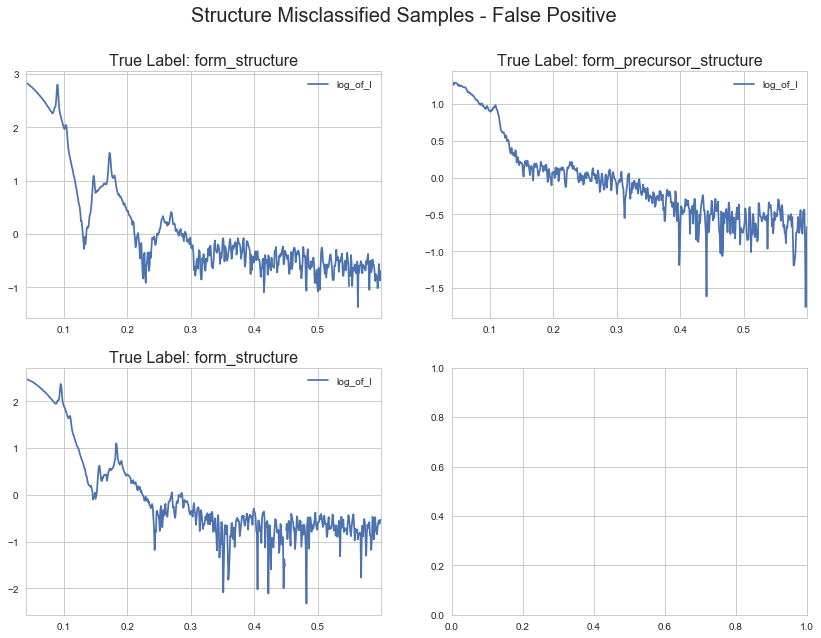

In [328]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Structure Misclassified Samples - False Positive", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    file_name = d.iloc[0]
    str_label = d.iloc[-6]
    df_v = pd.read_csv('2016_saxs_data/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

<a id=results></a>

# Unsupervised Learinig Results

### Bad Data, analytical features

|       | training / testing  
| ------------- | ------------- |----------------
| accuracy of PAWS labeling  | 0.78  
| KMean with PCA |** 0.947 / 0.970 ** 
| KMean | 0.969 / 0.945
| Birch | 0.963 / 0.940


### Precursor, 60 bins as features

|       | training / testing  
| ------------- | ------------- |----------------
| accuracy of PAWS labeling  | 0.55 
| KMean with PCA | 0.856 / 0.810 
| KMean | 0.852 / 0.810
| Birch | ** 0.846 / 0.814 **

### Form, 60 bins as features

|       | training / testing  
| ------------- | ------------- |----------------
| accuracy of PAWS labeling  | 0.91  
| KMean with PCA | 0.984 / 0.978 
| KMean | 0.988 / 1.0
| Birch | ** 0.995 / 1.0**

### Structure, analytical features

|       | training / testing  
| ------------- | ------------- |----------------
| accuracy of PAWS labeling  | 0.85  
| KMean with PCA | 0.966 / 0.978  
| KMean | **0.973 / 0.983 **
| Birch | **0.973 / 0.983**